https://colab.research.google.com/github/pytorch/pytorch.github.io/blob/master/assets/hub/mateuszbuda_brain-segmentation-pytorch_unet.ipynb

### This notebook is optionally accelerated with a GPU runtime.
### If you would like to use this acceleration, please select the menu option "Runtime" -> "Change runtime type", select "Hardware Accelerator" -> "GPU" and click "SAVE"

----------------------------------------------------------------------

# U-Net for brain MRI

*Author: mateuszbuda*

**U-Net with batch normalization for biomedical image segmentation with pretrained weights for abnormality segmentation in brain MRI**

<img src="https://pytorch.org/assets/images/unet_brain_mri.png" alt="alt" width="50%"/>

In [3]:
!ls

sample_data


In [28]:
import torch
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)


Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


Loads a U-Net model pre-trained for abnormality segmentation on a dataset of brain MRI volumes [kaggle.com/mateuszbuda/lgg-mri-segmentation](https://www.kaggle.com/mateuszbuda/lgg-mri-segmentation)
The pre-trained model requires 3 input channels, 1 output channel, and 32 features in the first layer.

### Model Description

This U-Net model comprises four levels of blocks containing two convolutional layers with batch normalization and ReLU activation function, and one max pooling layer in the encoding part and up-convolutional layers instead in the decoding part.
The number of convolutional filters in each block is 32, 64, 128, and 256.
The bottleneck layer has 512 convolutional filters.
From the encoding layers, skip connections are used to the corresponding layers in the decoding part.
Input image is a 3-channel brain MRI slice from pre-contrast, FLAIR, and post-contrast sequences, respectively.
Output is a one-channel probability map of abnormality regions with the same size as the input image.
It can be transformed to a binary segmentation mask by thresholding as shown in the example below.

### Example

Input images for pre-trained model should have 3 channels and be resized to 256x256 pixels and z-score normalized per volume.

In [29]:
# Download an example image
import urllib
url, filename = ("https://github.com/mateuszbuda/brain-segmentation-pytorch/raw/master/assets/TCGA_CS_4944.png", "TCGA_CS_4944.png")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

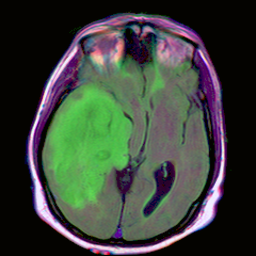

In [30]:
from IPython.display import Image
Image('/content/TCGA_CS_4944.png')  # Replace with the actual path

In [31]:
import numpy as np
from PIL import Image
from torchvision import transforms

input_image = Image.open(filename)
m, s = np.mean(input_image, axis=(0, 1)), np.std(input_image, axis=(0, 1))
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=m, std=s),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)

if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model = model.to('cuda')

with torch.no_grad():
    output = model(input_batch)

print(torch.round(output[0]))

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


In [32]:
torch.round(output[0]).shape

torch.Size([1, 256, 256])

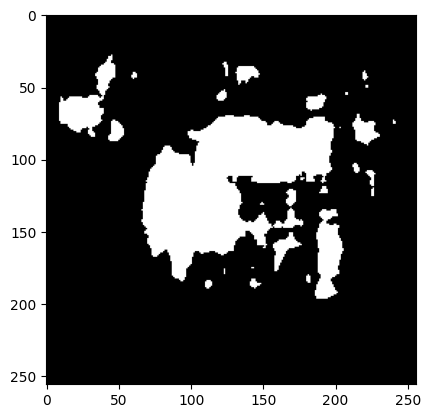

In [33]:
import matplotlib.pyplot as plt
import torch

# Assuming 'tensor' is your tensor with shape [1, 256, 256]
tensor =torch.round(output[0]).squeeze(0)  # Remove the first dimension (if it's a batch size of 1)
binary_mask_np = tensor.cpu().detach().numpy()  # Move to CPU, detach, and convert to NumPy

# Display as grayscale image
plt.imshow(binary_mask_np, cmap='gray')
plt.show()

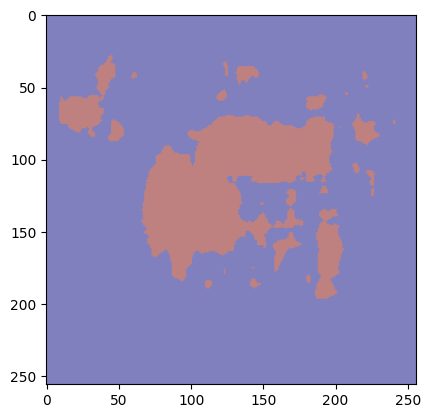

In [34]:
plt.imshow(binary_mask_np, alpha=0.5, cmap='jet')

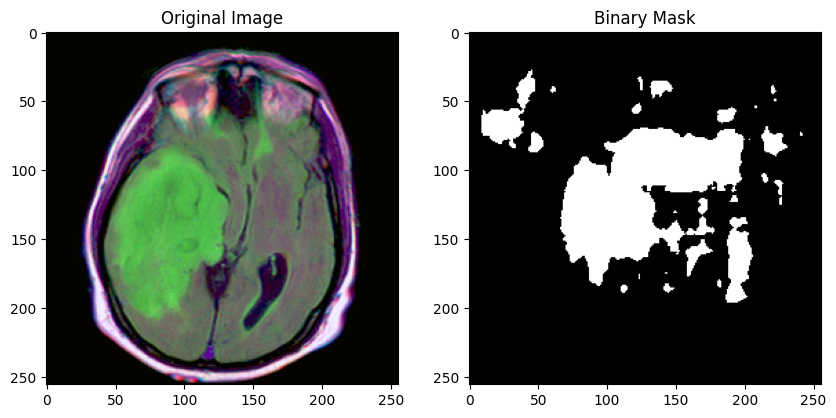

In [25]:
import matplotlib.pyplot as plt

# Assuming 'input_image' is your original image (PIL Image)
# and 'binary_mask_np' is your binary prediction mask (NumPy array)

# Display the original image and the binary mask side-by-side
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(input_image)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(binary_mask_np, cmap='gray')  # Use 'gray' colormap for binary mask
plt.title('Binary Mask')

plt.show()

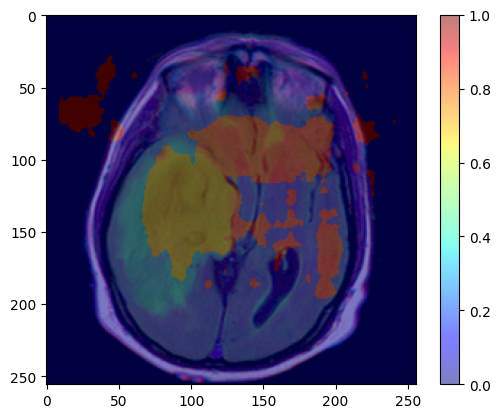

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'input_image' is your original image (PIL Image)
# and 'binary_mask_np' is your binary prediction mask (NumPy array)


plt.imshow(input_image)
plt.imshow(binary_mask_np, alpha=0.5, cmap='jet')  # Adjust alpha for transparency
plt.colorbar()
plt.show()

### References

- [Association of genomic subtypes of lower-grade gliomas with shape features automatically extracted by a deep learning algorithm](http://arxiv.org/abs/1906.03720)
- [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)
- [Brain MRI segmentation dataset](https://www.kaggle.com/mateuszbuda/lgg-mri-segmentation)